# Forecasting

In [2]:
from feature_generation import *

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
means = df.groupby("HistoryDate").mean()[targets]
means = means[:-135]
means = clean_data(means)
feature_set = get_feature_sets(means, targets)

## Calculating Error

Common way of calculating error in timeseries forecasting is [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [4]:
def mape_error(y_actual, y_pred, mean=True):
    result = 100 * ((y_actual - y_pred).abs() / y_actual)
    if mean:
        return result.mean()
    else:
        return result

## Base Error

To evaluate our models and see if they are useful, we need a base error to compare them with. One way of doing this is to use shifted data as predictions.

In [5]:
# input:            pandas dataframe representing the target variables, size of the window (must be higher than the highest value in averages parameter)
# input example:    average=[[7,14], [7,14,21]] calculate the averages of t-7 and t-14, then find MAPE with this average. Same for t-7, t-14 and t-21
def get_shifted_errors(y, size, average=[]):
    shifted_errors = pd.DataFrame(dtype='float64')
    for target in y.columns:
        windows = get_windows(y[target], size, drop_t=False)
        column_name = "%s_Error" % target
        for column in windows.columns[1:]:
            shifted_errors.loc[column, column_name] = mape_error(windows['t'], windows[column])

        for offsets in average:
            offsets = [str(offset) for offset in offsets]
            shifted_errors.loc['t-(%s)'%','.join(offsets), column_name] = mape_error(windows['t'], windows[['t-%s'%offset for offset in offsets]].mean(axis=1))
    
    return shifted_errors 

In [6]:
shifted_errors = get_shifted_errors(means[['CashOut', 'CashIn']], 21, average=[[7,14], [7,14,21]]).sort_values(by='CashOut_Error')

In [7]:
shifted_errors.sort_values(by='CashIn_Error')[:3]

,CashOut_Error,CashIn_Error
"t-(7,14,21)",27.691305,12.471977
"t-(7,14)",29.817590,13.395420
t-14,35.001829,14.631056


In [8]:
shifted_errors.sort_values(by='CashOut_Error')[:3]

,CashOut_Error,CashIn_Error
"t-(7,14,21)",27.691305,12.471977
t-1,29.274430,30.247342
"t-(7,14)",29.817590,13.395420


### Base errors:

Averages of t-7, t-14 and t-21 performed best for both features we want to predict.

* CashIn: 12.47
* CashOut: 27.69

## Forecasting

### Models to try:
* Random forest
* Lightgbm
* Catboost

## Random Forest

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [10]:
target = 'CashIn'

X = feature_set[feature_set.columns[2:]]
y = feature_set[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

forest = RandomForestRegressor(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

print("Predicting: %s" % target)

Predicting: CashIn


In [11]:
print("Training error: %.4f" % mape_error(forest.predict(X_train), y_train))
print("Testing error:  %.4f" % mape_error(forest.predict(X_test), y_test))


Training error: 3.8778
Testing error:  12.6803


In [13]:
from forecasting import draw_model_error

In [15]:
draw_model_error(forest, X, y, split_from=X_train.index[-1])

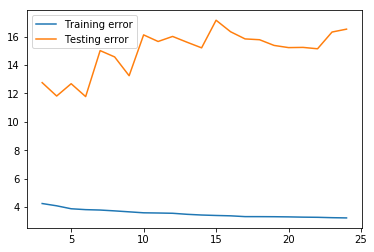

In [16]:
train_error = []
test_error = []
r = range(3,25)
for n_trees in r:
    forest = RandomForestRegressor(n_estimators=n_trees, random_state=2)
    forest.fit(X_train, y_train)

    train_error.append(mape_error(forest.predict(X_train), y_train))
    test_error.append(mape_error(forest.predict(X_test), y_test))

plt.plot(r, train_error, label='Training error')
plt.plot(r, test_error, label='Testing error')
plt.legend()
plt.show()

## LGBM and CatBoost

In [17]:
import optuna
from lightgbm import LGBMRegressor

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'mape', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mape_error(test_y, preds)
    
    return rmse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-07-05 18:18:44,784] A new study created in memory with name: no-name-9247cc5a-0b4f-4958-bcc0-772d580dba71
[I 2021-07-05 18:18:45,360] Trial 0 finished with value: 8.020702341540295 and parameters: {'reg_alpha': 0.0023825432015735434, 'reg_lambda': 0.009533689799963737, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 20, 'num_leaves': 902, 'min_child_samples': 136, 'min_data_per_groups': 24}. Best is trial 0 with value: 8.020702341540295.
[I 2021-07-05 18:18:45,707] Trial 1 finished with value: 7.80017247391451 and parameters: {'reg_alpha': 0.002671031001056567, 'reg_lambda': 0.7155042644333116, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 512, 'min_child_samples': 73, 'min_data_per_groups': 80}. Best is trial 1 with value: 7.80017247391451.
[I 2021-07-05 18:18:46,391] Trial 2 finished with value: 7.812431710196628 and parameters: {'reg_alpha': 0.8954868626450087, 'reg_lambda': 3.695868964099744

Number of finished trials: 20
Best trial: {'reg_alpha': 0.2655447111809072, 'reg_lambda': 0.277640459630931, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 715, 'min_child_samples': 5, 'min_data_per_groups': 47}
Best value: 7.327150551788111


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [18]:
#params=study.best_params   
params = {'reg_alpha': 0.2655447111809072, 'reg_lambda': 0.277640459630931, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 10, 'num_leaves': 715, 'min_child_samples': 5, 'min_data_per_groups': 47}
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'mape'
params['cat_smooth'] = params.pop('min_data_per_groups')

In [26]:
from sklearn.model_selection import KFold

folds = KFold(n_splits = 10, shuffle=False)

predictions = np.zeros(len(X_test))

for fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    
    X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    model = LGBMRegressor(**params)
   
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'mape', verbose = False, early_stopping_rounds = 222)
    
    predictions += model.predict(X_test) / folds.n_splits 

In [27]:
from forecasting import *

In [28]:
weekly_errors = get_weekly_error(y_test, predictions, 'w')
draw_error_over_time(y_test, predictions, weekly_errors)

In [30]:
"Test error of LGBM is %.3f." % mape_error(y_test, predictions)

'Test error of LGBM is 8.666.'